In [1]:
# Install the required libraries: Run this in your terminal:
! pip install tensorflow scikit-learn

In [2]:
! pip install tensorflow scikit-learn matplotlib pandas

C:\Users\hanss\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0148
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0023
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0011
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/s

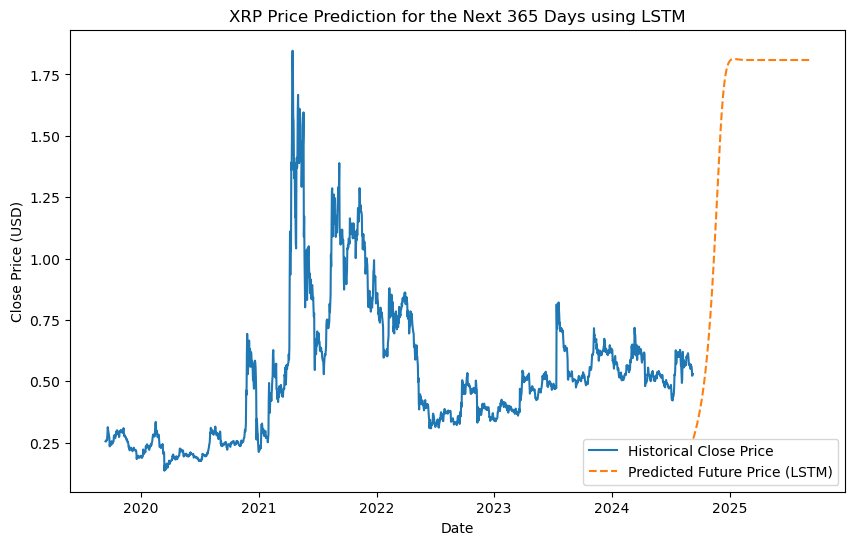

In [3]:
# Implement Hybrid Model

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your data (replace with your own data if necessary)
xrp_data = pd.read_csv('ripple_2019-09-11_2024-09-09.csv')

# Use the 'End' column as the date
xrp_data['End'] = pd.to_datetime(xrp_data['End'])
close_price = xrp_data['Close'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))

# Prepare the data for the LSTM model
def create_lstm_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # We use 60 days of historical data to predict the next price
X_train, y_train = create_lstm_dataset(scaled_data, time_step)

# Reshape the input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

# Prepare test data (the last 60 days of data)
test_data = scaled_data[-time_step:]
X_test = []
X_test.append(test_data)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the next 365 days
predicted_prices = []
for _ in range(365):  # Change 30 to 365 for a 365-day prediction
    prediction = model.predict(X_test)
    
    # Apply constraints: ensure the prediction is non-negative
    prediction = max(prediction[0, 0], 0)
    predicted_prices.append(prediction)

    # Reshape the prediction to match the dimensions of X_test before appending
    prediction_reshaped = np.reshape(prediction, (1, 1, 1))
    X_test = np.append(X_test[:, 1:, :], prediction_reshaped, axis=1)

# Rescale the predicted prices back to the original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create future dates for the predictions
future_dates = pd.date_range(xrp_data['End'].max(), periods=365, freq='D')  # Extend to 365 days

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(xrp_data['End'], close_price, label='Historical Close Price')
plt.plot(future_dates, predicted_prices, label='Predicted Future Price (LSTM)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('XRP Price Prediction for the Next 365 Days using LSTM')
plt.legend()
plt.show()

